# CARA: robust annotation and discovery of novel cell types in single-cell ATAC-seq data through cross-modal reference alignment
This notebook implements the CARA workflow for analyzing single-cell RNA-seq and ATAC-seq data. 

In [1]:
# Standard library imports
import os
import time as tm
import warnings

# Third-party imports
import numpy as np
import torch
import matplotlib.pyplot as plt
import anndata as ad
import pyro
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import ExponentialLR

# Local imports
from util.util import *
from util.dataloader import *
from util.ood import *
from model.model import cara

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

## Configuration

Set up hyperparameters and file paths. Modify these values according to your environment.

In [2]:
class Config:
    # Data Paths
    # Use relative paths for portability
    RNA_PATH = "/home/data/CITE-ASAP/adata_rna_cache.h5ad"
    ATAC_PATH = "/home/data/CITE-ASAP/adata_rna_cache.h5ad"
    OUTPUT_PATH = os.path.join("output", "pbmc2")
    PREFIX = "pbmc2_1127"
    
    # Model Hyperparameters
    HIDDEN_SIZE = 200
    NO_CLASS = 14        # Total number of classes
    
    # Training Hyperparameters
    SEED = 233
    LEARNING_RATE = 1e-4
    DECAY_RATE = 0.97
    BATCH_SIZE = 60
    EPOCHS = 40
    WARMUP_EPOCHS = 30
    WARMUP2_EPOCHS = 100
    PATIENCE = 50
    
    # Other settings
    USE_CUDA = True
    NUM_WORKERS = 0
    SAVE_MODEL = False
    
    # Pyro settings
    ENUM_DISCRETE = "parallel"
    CONFIG_ENUM = "parallel"
    
    # Dataset splitting
    TEST_SIZE = 0.2
    VALID_SIZE = 0.1

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_PATH, exist_ok=True)

# Set random seed for reproducibility
setup(Config.SEED)

# Check CUDA availability
cuda = Config.USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

Load RNA and ATAC data, preprocess, and align features.

In [3]:
labeled_rna_trainloader, test_rna_loader_all, labeled_atac_trainloader, unlabeled_atac_trainloader, atac_test_loader, index_to_category, batch_num, dataset, data = load_and_process_data(Config)

Loading ATAC data from /home/data/CITE-ASAP/adata_rna_cache.h5ad...
Finding HVGs for RNA data...
Finding HVGs for ATAC data...

Number of RNA HVGs: 3000
Number of ATAC HVGs: 3000
Total number of unique HVGs in union: 3000

Converting RNA data to DataFrame for reshaping...
Converting ATAC data to DataFrame...

Aligning RNA data using reindex (filling missing genes with 0)...
Aligning ATAC data using reindex (filling missing genes with 0)...

Converting aligned DataFrames back to AnnData objects...

--- Verification ---
Final RNA data shape: (4644, 3000)
Final ATAC data shape: (4644, 3000)

Success! 'rna_final' and 'atac_final' now have identical and ordered features.
Data alignment complete.
DataLoaders created.


## Model Initialization

Initialize the TRE model and optimizer.

In [4]:
input_size_rna = dataset['rna_train_labeled_dataset'].data.shape[1]
input_size_atac = dataset['atac_train_labeled_dataset'].data.shape[1]
output_size_rna = Config.NO_CLASS

scc = cara(
    output_size=output_size_rna,
    rna_input_size=input_size_rna,
    atac_input_size=input_size_atac,
    z_dim=Config.HIDDEN_SIZE, 
    hidden_layers=[500],
    batch_num=batch_num,
    use_cuda=cuda,
    config_enum=Config.ENUM_DISCRETE,
    use_class_weights=True,
    aux_loss_multiplier=50,
    alpha=0.001,
)

# Setup optimizer
adam_params = {'lr': Config.LEARNING_RATE, 'betas': (0.99, 0.999), 'weight_decay': 1e-4}
optimizer = torch.optim.Adam
scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': Config.DECAY_RATE})

pyro.clear_param_store()

# Setup losses
guide = config_enumerate(scc.guide, Config.ENUM_DISCRETE, expand=True)
elbo = TraceEnum_ELBO(max_plate_nesting=1, strict_enumeration_warning=False)
loss_basic = SVI(scc.model, guide, scheduler, loss=elbo)

losses = [loss_basic]
aux_loss = True
if aux_loss:
    elbo_aux = Trace_ELBO()
    loss_aux = SVI(scc.model_classify, scc.guide_classify, scheduler, loss=elbo_aux)
    losses.append(loss_aux)

## Training


Starting RNA Warmup...
Epoch 1: Loss 4872.9131
Epoch 2: Loss 4482.6142
Epoch 3: Loss 4427.6560
Epoch 4: Loss 4401.7378
Epoch 5: Loss 4382.2001
Epoch 6: Loss 4368.4227
Epoch 7: Loss 4359.0983
Epoch 8: Loss 4347.8907
Epoch 9: Loss 4339.3727
Epoch 10: Loss 4332.1606
Epoch 11: Loss 4323.3738
Epoch 12: Loss 4311.3490
Epoch 13: Loss 4302.9811
Epoch 14: Loss 4293.8150
Epoch 15: Loss 4286.0993
Epoch 16: Loss 4277.8224
Epoch 17: Loss 4269.8210
Epoch 18: Loss 4264.8875
Epoch 19: Loss 4254.9404
Epoch 20: Loss 4245.6053
Epoch 21: Loss 4240.7818
Epoch 22: Loss 4235.5073
Epoch 23: Loss 4229.1116
Epoch 24: Loss 4223.0606
Epoch 25: Loss 4217.0624
Epoch 26: Loss 4215.1729
Epoch 27: Loss 4209.0316
Epoch 28: Loss 4204.1594
Epoch 29: Loss 4199.9828
Epoch 30: Loss 4194.2451
RNA Warmup Done. Best Val Acc: 0.9993


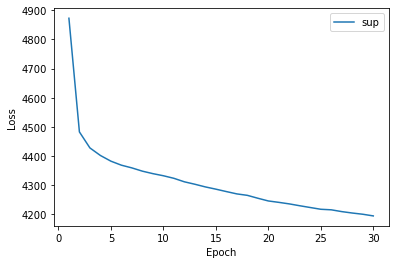

In [5]:
print("Starting RNA Warmup...")
scc.compute_initial_class_weights(labeled_rna_trainloader)

best_valid_acc = 0.0
tr_start = tm.time()
supplosses = []

for i in range(Config.WARMUP_EPOCHS):
    ep_tr_start = tm.time()
    sup_num = len(labeled_rna_trainloader.dataset)
    
    epoch_losses_sup = run_inference_for_epoch_warmup(labeled_rna_trainloader, losses, cuda)
    avg_epoch_losses_sup = [loss / sup_num for loss in epoch_losses_sup]
    supplosses.append(avg_epoch_losses_sup[0])
    
    # Validation
    validation_accuracy, validation_f1_macro, _, _, _, _, ARI, NMI = get_accuracy(
        test_rna_loader_all, scc.classifier
    )
    
    ep_tr_time = tm.time() - ep_tr_start
    print(f"Epoch {i+1}: Loss {avg_epoch_losses_sup[0]:.4f}")
    
    if validation_accuracy > best_valid_acc:
        best_valid_acc = validation_accuracy

print(f"RNA Warmup Done. Best Val Acc: {best_valid_acc:.4f}")

# Plot Loss
plt.figure()
plt.plot(range(1, len(supplosses) + 1), supplosses, label='sup')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [6]:
# Freeze classifier
freeze_classifier(scc)
scc.compute_initial_class_weights(labeled_atac_trainloader)

supplosses = []
best_valid_acc = 0.0

print("Starting ATAC Training...")
for i in range(Config.WARMUP2_EPOCHS):
    ep_tr_start = tm.time()
    sup_num = len(labeled_atac_trainloader.dataset)
    unsup_num = len(unlabeled_atac_trainloader.dataset)
    
    epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
        losses, labeled_atac_trainloader, unlabeled_atac_trainloader, cuda
    )
    
    avg_loss_sup = epoch_losses_sup[0] / sup_num
    supplosses.append(avg_loss_sup)
    
    # Validation
    validation_accuracy, _, _, _, _, _, ARI, NMI = get_accuracy(
        atac_test_loader, scc.classifier
    )
    
    print(f"Epoch {i+1}: Loss {avg_loss_sup:.4f}")
    
    if validation_accuracy > best_valid_acc:
        best_valid_acc = validation_accuracy
        
print(f"ATAC Trainng Done. Best Val Acc: {best_valid_acc:.4f}")

Starting ATAC Training...
Epoch 1: Loss 18768.4724
Epoch 2: Loss 17535.3158
Epoch 3: Loss 17394.1818
Epoch 4: Loss 17285.6613
Epoch 5: Loss 17171.1666
Epoch 6: Loss 17114.1458
Epoch 7: Loss 17041.8335
Epoch 8: Loss 16989.9754
Epoch 9: Loss 16932.9930
Epoch 10: Loss 16910.2933
Epoch 11: Loss 16835.8535
Epoch 12: Loss 16828.2097
Epoch 13: Loss 16769.1517
Epoch 14: Loss 16743.6311
Epoch 15: Loss 16710.3518
Epoch 16: Loss 16686.3624
Epoch 17: Loss 16664.1695
Epoch 18: Loss 16621.0342
Epoch 19: Loss 16587.7772
Epoch 20: Loss 16581.6506
Epoch 21: Loss 16545.1117
Epoch 22: Loss 16525.5845
Epoch 23: Loss 16485.6746
Epoch 24: Loss 16464.2470
Epoch 25: Loss 16461.2737
Epoch 26: Loss 16417.6957
Epoch 27: Loss 16408.2659
Epoch 28: Loss 16387.9688
Epoch 29: Loss 16380.4560
Epoch 30: Loss 16365.7239
Epoch 31: Loss 16343.6043
Epoch 32: Loss 16339.4577
Epoch 33: Loss 16284.8459
Epoch 34: Loss 16283.6829
Epoch 35: Loss 16235.5171
Epoch 36: Loss 16245.3746
Epoch 37: Loss 16221.1275
Epoch 38: Loss 16206.

## Evaluation and Visualization

Visualize the results using UMAP.

 test accuracy 0.8945 F1 0.8863(macro) 0.8953(weighted) precision 0.8977 recall 0.8800 mcc 0.8678 ARI 0.7827 NMI 0.7621


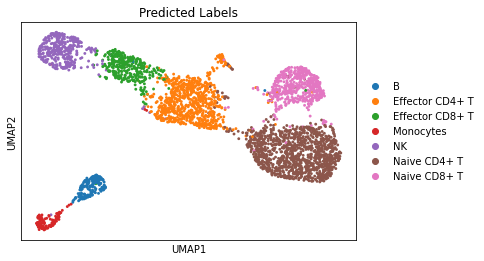

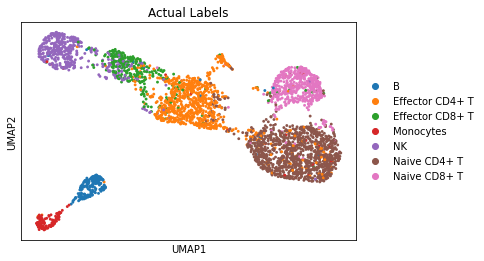

accuracy:0.8923, precision_macro:0.8983, precision_weighted:0.8974, recall_macro:0.8773, recall_weighted:0.8923, f1_macro:0.8853, f1_weighted:0.8930, ARI:0.7780, NMI:0.7581, jaccard:0.8010, fm:0.8241, v_measure:0.7581, purity:0.8923


{'accuracy': 0.8923497267759563,
 'precision_macro': 0.8983270860450778,
 'precision_weighted': 0.8973936651209962,
 'recall_macro': 0.877341243672175,
 'recall_weighted': 0.8923497267759563,
 'f1_macro': 0.8853187392012646,
 'f1_weighted': 0.8929605907268796,
 'ARI': 0.7780044769328688,
 'NMI': 0.7581036203921742,
 'jaccard': 0.8010204464865703,
 'fm': 0.8240979733159812,
 'v_measure': 0.7581036203921742,
 'purity': 0.8923497267759563}

In [10]:
# Save model
if Config.SAVE_MODEL:
    save_path = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}.pkl")
    torch.save(scc.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# Final Evaluation
predictions, scores, actuals, zs, zys, batchs, exps, barcodes, elbo_loss, metrics = evaluate(atac_test_loader, scc, loss_basic)


testadata = data['ATACCE_test'][barcodes, :].copy()
testadata.obsm["embedding"] = zys
testadata.obsm['prob'] = scores
testadata.obs['elbo_loss'] = elbo_loss[:testadata.shape[0],:]

# UMAP Visualization
sc.pp.neighbors(testadata, use_rep="embedding", n_neighbors=30)
sc.tl.umap(testadata, min_dist=0.3)

# Map predictions to names
testadata.obs['predictions'] = map_indices_to_names([index[0] for index in predictions], index_to_category)

# Plot Predictions
sc.pl.umap(testadata, color=['predictions'], show=False, title="Predicted Labels")
outputfig1 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_predict_label.pdf")
plt.savefig(outputfig1, format="pdf")
plt.show()

# Plot Actual Labels
sc.pl.umap(testadata, color=['cell_type'], show=False, title="Actual Labels")
outputfig2 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_actual_label.pdf")
plt.savefig(outputfig2, format="pdf")
plt.show()

# Compute Metrics
groundtruth = testadata.obs['cell_type']
originalcell = testadata.obs['predictions']
compute_metrics(groundtruth, originalcell)

In [13]:
testadata

AnnData object with n_obs × n_vars = 3660 × 3000
    obs: 'cell_type', 'data_type', 'batch', 'omic', 'predictions'
    uns: 'neighbors', 'umap', 'predictions_colors', 'cell_type_colors'
    obsm: 'embedding', 'prob', 'elbo_loss', 'X_umap'
    obsp: 'distances', 'connectivities'

# Novel Cell Type Dectection


--- Step 3: Execute Three-Score Voting Mechanism ---
MSP Voting: 6 cells marked as bad cells (Threshold: 0.5)
Entropy Threshold (based on 0.9 quantile): 0.1503
Entropy Voting: 366 cells marked as bad cells
Total bad cells: 366/3660 (10.00%)

--- Step 4: Identify OOD Clusters ---
Identified 1 OOD clusters: ['21']

Cluster Analysis Results:
Cluster 0: 254 cells, 21 bad cells, proportion: 0.083 (Normal)
Cluster 1: 246 cells, 52 bad cells, proportion: 0.211 (Normal)
Cluster 2: 235 cells, 21 bad cells, proportion: 0.089 (Normal)
Cluster 3: 233 cells, 15 bad cells, proportion: 0.064 (Normal)
Cluster 4: 226 cells, 29 bad cells, proportion: 0.128 (Normal)
Cluster 5: 200 cells, 11 bad cells, proportion: 0.055 (Normal)
Cluster 6: 197 cells, 23 bad cells, proportion: 0.117 (Normal)
Cluster 7: 193 cells, 18 bad cells, proportion: 0.093 (Normal)
Cluster 8: 178 cells, 2 bad cells, proportion: 0.011 (Normal)
Cluster 9: 169 cells, 1 bad cells, proportion: 0.006 (Normal)
Cluster 10: 164 cells, 11 bad 

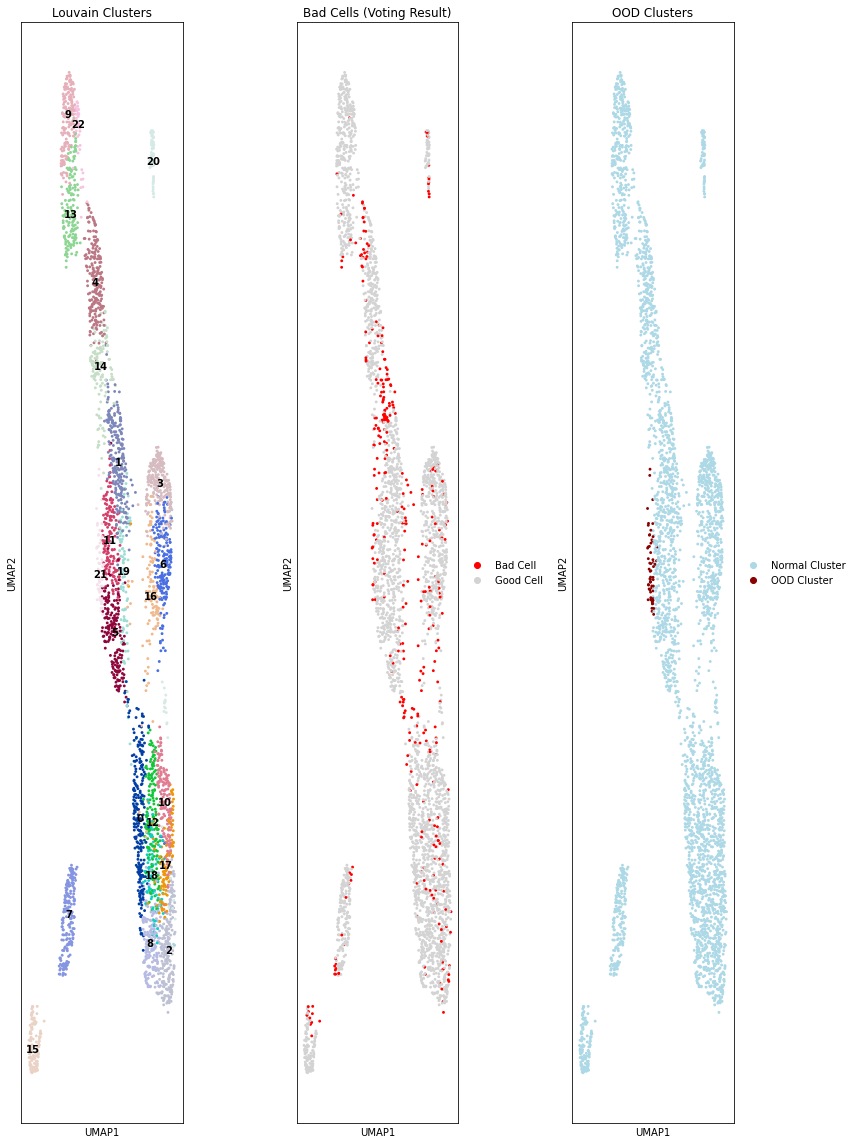

In [8]:

cluster_results = novel_cluster_detection(
    testadata, 
    resolution=2,
    msp_threshold=0.5,       
    entropy_quantile=0.9,     
    elbo_quantile=0.9,        
    ood_proportion_threshold=0.3  
)

In [9]:
print(f"Before update, value distribution of '{'predictions'}' column:\n", testadata.obs['predictions'].value_counts()) 
testadata = label_novel_cells_as_unknown(testadata, cell_type_key='predictions') 
print(f"\nAfter update, value distribution of '{'predictions'}' column:\n", testadata.obs['predictions'].value_counts())   


Before update, value distribution of 'predictions' column:
 predictions
Naive CD4+ T       1247
Effector CD4+ T     797
Naive CD8+ T        537
NK                  390
Effector CD8+ T     371
B                   188
Monocytes           130
Name: count, dtype: int64

--- 步骤 4: 将 OOD 簇中的细胞标记为 'unknown' (在 'predictions' 列) ---
找到了 60 个细胞属于 OOD 簇。
已将 60 个细胞的类型更新为 'unknown'。

After update, value distribution of 'predictions' column:
 predictions
Naive CD4+ T       1247
Effector CD4+ T     748
Naive CD8+ T        537
NK                  388
Effector CD8+ T     363
B                   188
Monocytes           129
unknown              60
Name: count, dtype: int64


更新后算指标+可视化